## 1. 把標記檔案 (.json) 轉成 mask(.png)
## 2. training

### 把標記檔案 (.json) 轉成 mask(.png)

In [1]:
import os
import json
import numpy as np
import cv2

def process_json(json_file, output_folder):
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    image_height = data['imageHeight']
    image_width = data['imageWidth']
    shapes = data['shapes']
    
    image = np.zeros((image_height, image_width), dtype=np.uint8)
    
    # Define colors for different labels
    label_colors = {
        'target': 255  # 白色 (255)  
    }
    
    # Draw shapes on the image
    for shape in shapes:
        label = shape['label']
        shape_type = shape['shape_type']
        points = shape['points']
        
        if points and label in label_colors:
            if shape_type == "polygon":
                points = np.array(points, dtype=np.int32)
                cv2.fillPoly(image, [points], color=label_colors[label])  # Fill polygon with the specific color
            elif shape_type == "circle":
                # 計算圓心和半徑
                point1 = np.array(points[0])  # 第一個點
                point2 = np.array(points[1])  # 第二個點
                center = ((point1 + point2) / 2).astype(int)  # 圆心
                radius = int(np.linalg.norm(point1 - point2) / 2)  # 半径
                cv2.circle(image, tuple(center), radius, label_colors[label], thickness=-1)  # ㄏㄨ
    
    # Save the image as PNG in the output folder
    output_png = os.path.join(output_folder, os.path.splitext(os.path.basename(json_file))[0] + '.png')
    cv2.imwrite(output_png, image)

# 處理整個資料夾的函數
def process_folder(input_folder, output_folder):
    # 確保輸出資料夾存在，若不存在則創建
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # 處理資料夾中的每個 JSON 文件
    for filename in os.listdir(input_folder):
        if filename.endswith('.json'):
            json_file = os.path.join(input_folder, filename)
            process_json(json_file, output_folder)

# 使用示例：指定輸入資料夾和輸出資料夾
input_folder = "C:/Users/Wu Lab/Desktop/sam2/dataset/jsons"  # 輸入資料夾路徑
output_folder = "C:/Users/Wu Lab/Desktop/sam2/dataset/masks"  # 輸出資料夾路徑

# 處理整個資料夾中的 JSON 文件
process_folder(input_folder, output_folder)


### training

C:\Users\Wu Lab\AppData\Local\Temp\ipykernel_1392\3471207796.py:46: RuntimeWarning: overflow encountered in scalar add
  mat_map[mat_map == 0] = ves_map[mat_map == 0] * (mat_map.max() + 1)  # merge maps


tensor(0.0018, device='cuda:0', grad_fn=<MeanBackward0>)
Model saved.
step 0 Accuracy(IOU)= 9.3998235e-05
tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>)
step 1 Accuracy(IOU)= tensor([0.0172, 0.0001, 0.0088, 0.0001, 0.0162, 0.0086, 0.0083, 0.0088, 0.0173,
        0.0084, 0.0087, 0.0090, 0.0089, 0.0090, 0.0083, 0.0099, 0.0001, 0.0094,
        0.0001, 0.0095, 0.0093, 0.0092, 0.0001, 0.0093, 0.0102, 0.0093, 0.0090,
        0.0102, 0.0094, 0.0088, 0.0181, 0.0100, 0.0093, 0.0100, 0.0090, 0.0094,
        0.0100, 0.0180, 0.0099, 0.0089, 0.0176, 0.0192, 0.0176, 0.0175, 0.0172,
        0.0086, 0.0274, 0.0562], device='cuda:0')
tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>)
step 2 Accuracy(IOU)= tensor([0.0079, 0.0086, 0.0001, 0.0249, 0.0465, 0.0001, 0.0087, 0.0001, 0.0096,
        0.0085, 0.0099, 0.0086, 0.0088, 0.0101, 0.0179, 0.0167, 0.0098, 0.0087,
        0.0001, 0.0101, 0.0089, 0.0101, 0.0097, 0.0093, 0.0091, 0.0091, 0.0100,
        0.0090, 0.0089, 0.0098, 0.0089, 0.0085

ValueError: x and y must have same first dimension, but have shapes (1,) and (0,)

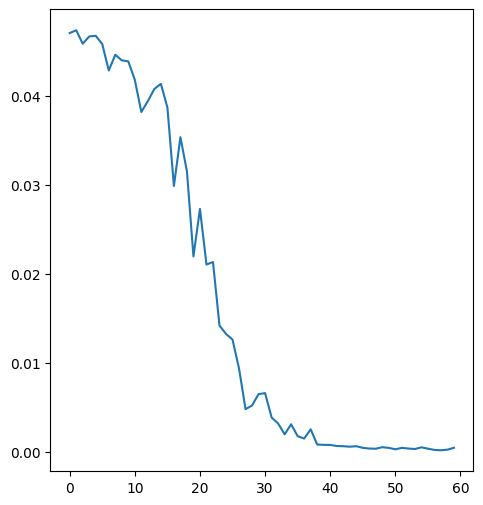

In [10]:
import numpy as np
import torch
import cv2
import os
import matplotlib.pyplot as plt
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

train_losses = []
train_ious = []
validation_losses = []
validation_ious = []
# Read data
data_dir = r'C:/Users/Wu Lab/Desktop/sam2/dataset/'  # Path to dataset (LabPics 1)
data = []  # list of files in dataset
for name in os.listdir(data_dir + "images/"):  # go over all folder annotation
    data.append({"image": data_dir + "images/" + name, "annotation": data_dir + "masks/" + name})


def read_batch(data, idx):  # read image and its annotation from the dataset (LabPics) based on index

    # select image based on index
    ent = data[idx]
    
    # Try to read the image
    Img = cv2.imread(ent["image"])
    if Img is None:
        print(f"Error: Cannot read image file {ent['image']}")
        return None, None, None, None
    Img = Img[..., ::-1]  # convert BGR to RGB
    
    # Try to read the annotation
    ann_map = cv2.imread(ent["annotation"])
    if ann_map is None:
        print(f"Error: Cannot read annotation file {ent['annotation']}")
        return None, None, None, None

    # resize image
    r = np.min([1024 / Img.shape[1], 1024 / Img.shape[0]])  # scaling factor
    Img = cv2.resize(Img, (int(Img.shape[1] * r), int(Img.shape[0] * r)))
    ann_map = cv2.resize(ann_map, (int(ann_map.shape[1] * r), int(ann_map.shape[0] * r)), interpolation=cv2.INTER_NEAREST)

    # merge vessels and materials annotations
    mat_map = ann_map[:, :, 0]  # material annotation map
    ves_map = ann_map[:, :, 2]  # vessel annotation map
    mat_map[mat_map == 0] = ves_map[mat_map == 0] * (mat_map.max() + 1)  # merge maps

    # Get binary masks and points
    inds = np.unique(mat_map)[1:]  # load all indices
    points = []
    masks = []
    for ind in inds:
        mask = (mat_map == ind).astype(np.uint8)  # make binary mask corresponding to index ind
        masks.append(mask)
        coords = np.argwhere(mask > 0)  # get all coordinates in mask
        yx = np.array(coords[np.random.randint(len(coords))])  # choose random point/coordinate
        points.append([[yx[1], yx[0]]])
    return Img, np.array(masks), np.array(points), np.ones([len(masks), 1])

# def validate_model(predictor, validation_data):
#     val_losses = []
#     val_ious = []

#     for idx in range(len(validation_data)):
#         image, mask, input_point, input_label = read_batch(validation_data, idx)
#         if image is None or mask.shape[0] == 0:
#             continue
        
#         with torch.no_grad():
#             predictor.set_image(image)
#             # 使用與訓練相同的預測過程，計算 loss 和 iou
#             # ...
#             # val_loss 和 val_iou 計算邏輯與訓練相同

#         val_losses.append(loss.item())
#         val_ious.append(np.mean(iou.cpu().numpy()))

#     return np.mean(val_losses), np.mean(val_ious)  
# Load model
sam2_checkpoint = "C:/Users/Wu Lab/Desktop/sam2/checkpoints/sam2_hiera_large.pt"  # path to model weight
model_cfg = "C:/Users/Wu Lab/Desktop/sam2/sam2_configs/sam2_hiera_l.yaml"  # model config
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")  # load model
predictor = SAM2ImagePredictor(sam2_model)

# Set training parameters
predictor.model.sam_mask_decoder.train(True)  # enable training of mask decoder
predictor.model.sam_prompt_encoder.train(True)  # enable training of prompt encoder
optimizer = torch.optim.AdamW(params=predictor.model.parameters(), lr=1e-5, weight_decay=4e-5)
scaler = torch.cuda.amp.GradScaler()  # mixed precision

# Training loop
total_steps = len(data)  # Total number of steps equals the number of images
for itr in range(total_steps):  # 100 epochs
    idx = itr % len(data)  # Modulus to loop over the dataset repeatedly
    with torch.cuda.amp.autocast():  # cast to mix precision
        image, mask, input_point, input_label = read_batch(data, idx)  # load data batch based on index

        
        # If the image or annotation could not be read, skip this iteration
        if image is None or mask is None:
            continue
        
        if mask.shape[0] == 0: continue  # ignore empty batches
        predictor.set_image(image)  # apply SAM image encoder to the image

        # prompt encoding
        mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(input_point, input_label, box=None, mask_logits=None, normalize_coords=True)
        sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(points=(unnorm_coords, labels), boxes=None, masks=None)

        # mask decoder
        batched_mode = unnorm_coords.shape[0] > 1  # multi-object prediction
        high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]
        low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0), image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(), sparse_prompt_embeddings=sparse_embeddings, dense_prompt_embeddings=dense_embeddings, multimask_output=True, repeat_image=batched_mode, high_res_features=high_res_features)
        prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])  # Upscale the masks to the original image resolution

        # Segmentation Loss calculation
        gt_mask = torch.tensor(mask.astype(np.float32)).cuda()
        prd_mask = torch.sigmoid(prd_masks[:, 0])  # Turn logit map to probability map
        seg_loss = (-gt_mask * torch.log(prd_mask + 0.00001) - (1 - gt_mask) * torch.log((1 - prd_mask) + 0.00001)).mean()  # cross entropy loss
        print(seg_loss)
        # Score loss calculation (intersection over union) IOU
        inter = (gt_mask * (prd_mask > 0.5)).sum(1).sum(1)
        iou = inter / (gt_mask.sum(1).sum(1) + (prd_mask > 0.5).sum(1).sum(1) - inter)
        score_loss = torch.abs(prd_scores[:, 0] - iou).mean()
        loss = seg_loss + score_loss * 0.05  # mix losses

        mean_iou = iou
        train_losses.append(loss.item())
        train_ious.append(mean_iou)
        # apply back propagation
        predictor.model.zero_grad()  # empty gradient
        scaler.scale(loss).backward()  # Backpropagate
        scaler.step(optimizer)
        scaler.update()  # Mix precision
        
        if itr % 1000 == 0:
            # val_loss, val_iou = validate_model(predictor, validation_data)
            # validation_losses.append(val_loss)
            # validation_ious.append(val_iou)
            # print(f"Validation - Step {itr}, Loss: {val_loss}, IOU: {val_iou}")
            torch.save(predictor.model.state_dict(), "model.torch")
            print("Model saved.")

        # Display results
        if itr == 0: mean_iou = 0
        mean_iou = mean_iou * 0.99 + 0.01 * np.mean(iou.cpu().detach().numpy())
        print("step", itr, "Accuracy(IOU)=", mean_iou)

      
# 繪製 loss 和 accuracy 圖表
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(range(0, len(train_losses), 500), validation_losses, label='Validation Loss', marker='o')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# plt.subplot(1, 2, 2)
# plt.plot(train_ious, label='Train IOU')
# plt.plot(range(0, len(train_ious), 500), validation_ious, label='Validation IOU', marker='o')
# plt.xlabel('Iterations')
# plt.ylabel('IOU')
# plt.legend()
# plt.title('Training and Validation IOU')

plt.tight_layout()
plt.show()

### testing

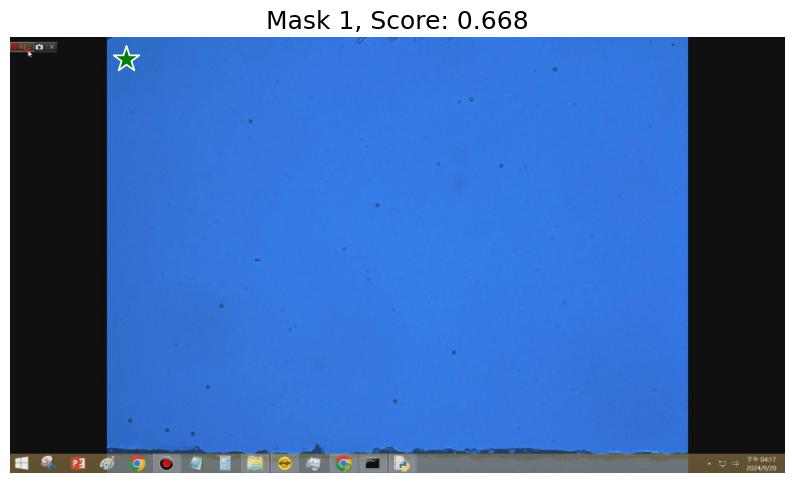

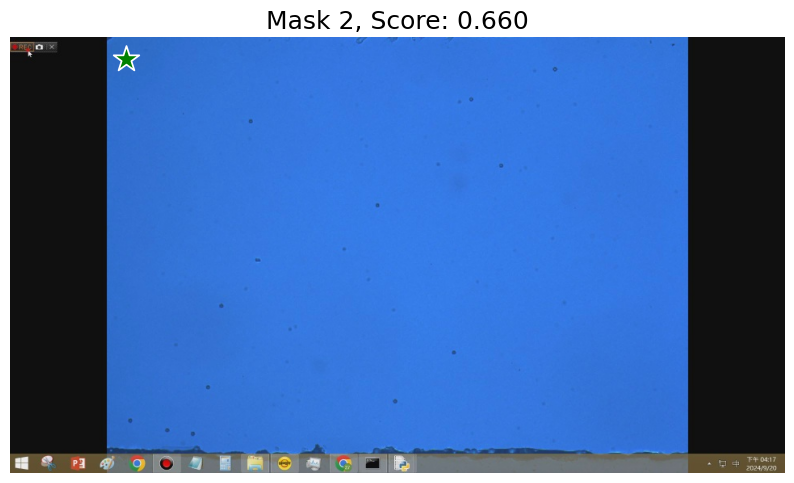

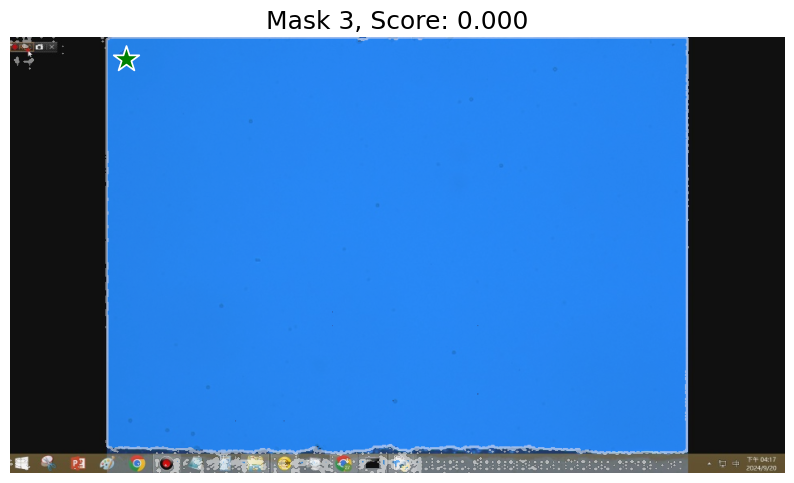

In [6]:
import numpy as np
import torch
import cv2
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

# use bfloat16 for the entire script (memory efficient)
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

sam2_checkpoint = "./checkpoints/sam2_hiera_large.pt"
model_cfg = "C:/Users/User/Desktop/sam2/sam2_configs/sam2_hiera_l.yaml"
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")

# Build net and load weights
predictor = SAM2ImagePredictor(sam2_model)
# predictor.model.load_state_dict(torch.load("model.torch"))

from PIL import Image
# image = Image.open("D:/dataset/new/img/T1102_20240808_042938_1038.png")
image = Image.open("C:/Users/User/Desktop/sam2/bandicam 2024-09-20 16-17-42-250/00000.jpeg")
image = np.array(image.convert("RGB"))

predictor.set_image(image)

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()
        
input_point = np.array([[143, 27]]) # T1409_030624_083437_677
input_label = np.array([1])
# input_points = np.array([[1000, 900], [700, 500]])
# input_labels = np.array([1, 1]) 

import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 10))
# plt.imshow(image)
# show_points(input_point, input_label, plt.gca())
# plt.axis('on')
# plt.show()  

masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]
scores = scores[sorted_ind]
logits = logits[sorted_ind]

show_masks(image, masks, scores, point_coords=input_point, input_labels=input_label, borders=True)

In [6]:
import numpy as np
import torch
import cv2
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from PIL import Image
import os

torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

sam2_checkpoint = "./checkpoints/sam2_hiera_large.pt"
model_cfg = "C:/Users/AUSER/Desktop/sam2_2/sam2_configs/sam2_hiera_l.yaml"
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")

predictor = SAM2ImagePredictor(sam2_model)
predictor.model.load_state_dict(torch.load("model.torch"))

image_dir = 'C:/Users/AUSER/Desktop/sam2_2/T1102_20240807_091406' # 影像資料夾路徑
output_dir = 'C:/Users/User/Desktop/sam2/影片預測結果/masks' # mask 資料夾路徑
os.makedirs(output_dir, exist_ok=True)

def save_binary_mask(mask, save_path):
    """
    Save the mask as a black-and-white binary image.
    White represents the mask area (255), and black represents the background (0).
    """
    # Convert mask to binary (0 and 255)
    binary_mask = (mask * 255).astype(np.uint8)
    # Save the binary mask as an image
    cv2.imwrite(save_path, binary_mask)

# Predict and save masks for all images in the directory
for image_filename in os.listdir(image_dir):
    if image_filename.lower().endswith(('.png', '.jpg', '.jpeg')):  # Adjust extensions as needed
        image_path = os.path.join(image_dir, image_filename)
        image = Image.open(image_path)
        image = np.array(image.convert("RGB"))

        predictor.set_image(image)

        input_point = np.array([[1000, 900], [1000, 910]])  # 設定點座標
        input_label = np.array([1, 1]) # 1: positive (有幾個點就要幾個)

        masks, scores, logits = predictor.predict(
            point_coords=input_point,
            point_labels=input_label,
            multimask_output=True,
        )

        # Sort masks by scores
        sorted_ind = np.argsort(scores)[::-1]
        masks = masks[sorted_ind]
        scores = scores[sorted_ind]
        logits = logits[sorted_ind]

        # Get the highest score mask
        highest_score_mask = masks[0]

        # Save the highest score mask as a black-and-white image
        save_path = os.path.join(output_dir, f"{os.path.splitext(image_filename)[0]}_mask.png")
        save_binary_mask(highest_score_mask, save_path)

print("Prediction complete.")

MissingConfigException: Cannot find primary config 'C:/Users/AUSER/Desktop/sam2_2/sam2_configs/sam2_hiera_l.yaml'. Check that it's in your config search path.

Config search path:
	provider=hydra, path=pkg://hydra.conf
	provider=main, path=pkg://sam2_configs
	provider=schema, path=structured://

參數測試

Training with learning_rate=1e-05, weight_decay=0.0001
Epoch 0, Val Loss: nan, Val IOU: nan
Model saved to C:/Users/Wu Lab/Desktop/sam2/parameter-model\model_test_lr_1e-05_wd_0.0001_epoch_0.pt
Epoch 1, Val Loss: nan, Val IOU: nan
Model saved to C:/Users/Wu Lab/Desktop/sam2/parameter-model\model_test_lr_1e-05_wd_0.0001_epoch_1.pt
Epoch 2, Val Loss: nan, Val IOU: nan
Model saved to C:/Users/Wu Lab/Desktop/sam2/parameter-model\model_test_lr_1e-05_wd_0.0001_epoch_2.pt
Epoch 3, Val Loss: nan, Val IOU: nan
Model saved to C:/Users/Wu Lab/Desktop/sam2/parameter-model\model_test_lr_1e-05_wd_0.0001_epoch_3.pt
Epoch 4, Val Loss: nan, Val IOU: nan
Model saved to C:/Users/Wu Lab/Desktop/sam2/parameter-model\model_test_lr_1e-05_wd_0.0001_epoch_4.pt


ValueError: x and y must have same first dimension, but have shapes (0,) and (5,)

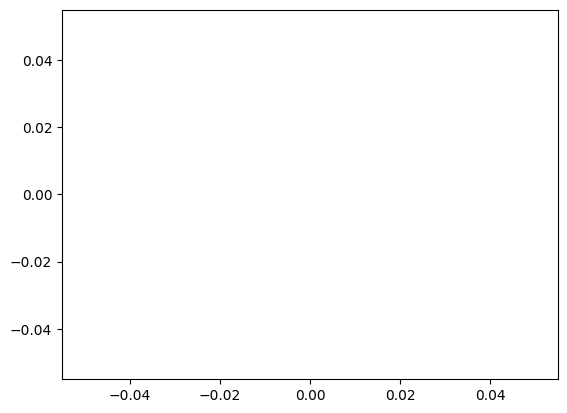

In [7]:
import numpy as np
import torch
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split  # 数据集划分
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

train_losses = []
train_ious = []
validation_losses = []
validation_ious = []
# Read data
data_dir = r'C:/Users/Wu Lab/Desktop/sam2/dataset/'  # Path to dataset (LabPics 1)
data = []  # list of files in dataset
for name in os.listdir(data_dir + "images/"):  # go over all folder annotation
    data.append({"image": data_dir + "images/" + name, "annotation": data_dir + "masks/" + name})


# 划分数据集函数
def split_dataset(data, validation_ratio=0.2):
    train_data, val_data = train_test_split(data, test_size=validation_ratio, random_state=42)
    return train_data, val_data

# 读取数据函数（保持不变）
def read_batch(data, idx):
    ent = data[idx]
    Img = cv2.imread(ent["image"])
    if Img is None or cv2.imread(ent["annotation"]) is None:
        return None, None, None, None
    Img = Img[..., ::-1]
    ann_map = cv2.imread(ent["annotation"])
    r = np.min([1024 / Img.shape[1], 1024 / Img.shape[0]])
    Img = cv2.resize(Img, (int(Img.shape[1] * r), int(Img.shape[0] * r)))
    ann_map = cv2.resize(ann_map, (int(ann_map.shape[1] * r), int(ann_map.shape[0] * r)), interpolation=cv2.INTER_NEAREST)
    mat_map = ann_map[:, :, 0]
    ves_map = ann_map[:, :, 2]
    mat_map[mat_map == 0] = ves_map[mat_map == 0] * (mat_map.max() + 1)
    inds = np.unique(mat_map)[1:]
    points, masks = [], []
    for ind in inds:
        mask = (mat_map == ind).astype(np.uint8)
        masks.append(mask)
        coords = np.argwhere(mask > 0)
        yx = np.array(coords[np.random.randint(len(coords))])
        points.append([[yx[1], yx[0]]])
    return Img, np.array(masks), np.array(points), np.ones([len(masks), 1])

import os
import numpy as np
import torch
import matplotlib.pyplot as plt

# 验证函数
def validate_model(predictor, val_data):
    val_losses, val_ious = [], []
    for idx in range(len(val_data)):
        image, mask, input_point, input_label = read_batch(val_data, idx)
        if image is None or mask.shape[0] == 0:
            continue
        with torch.no_grad():
            predictor.set_image(image)
            mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(
                input_point, input_label, box=None, mask_logits=None, normalize_coords=True
            )
            sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(
                points=(unnorm_coords, labels), boxes=None, masks=None
            )
            high_res_features = [feat[-1].unsqueeze(0) for feat in predictor._features["high_res_feats"]]
            low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(
                image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),
                image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
                sparse_prompt_embeddings=sparse_embeddings,
                dense_prompt_embeddings=dense_embeddings,
                multimask_output=True,
                repeat_image=unnorm_coords.shape[0] > 1,
                high_res_features=high_res_features,
            )
            prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])
            gt_mask = torch.tensor(mask.astype(np.float32)).cuda()
            prd_mask = torch.sigmoid(prd_masks[:, 0])
            seg_loss = (-gt_mask * torch.log(prd_mask + 1e-5) - (1 - gt_mask) * torch.log(1 - prd_mask + 1e-5)).mean()
            inter = (gt_mask * (prd_mask > 0.5)).sum(1).sum(1)
            iou = inter / (gt_mask.sum(1).sum(1) + (prd_mask > 0.5).sum(1).sum(1) - inter)
            val_losses.append(seg_loss.item())
            val_ious.append(iou.mean().cpu().item())
    return np.mean(val_losses), np.mean(val_ious)

# 主训练函数
def train_sam2(data, learning_rates, weight_decays, epochs, batch_size, save_dir):
    # 划分数据集
    train_data, val_data = split_dataset(data)

    # 超参数网格搜索
    for lr in learning_rates:
        for wd in weight_decays:
            print(f"Training with learning_rate={lr}, weight_decay={wd}")

            # 加载模型
            sam2_checkpoint = "C:/Users/Wu Lab/Desktop/sam2/checkpoints/sam2_hiera_large.pt"
            model_cfg = "C:/Users/Wu Lab/Desktop/sam2/sam2_configs/sam2_hiera_l.yaml"
            sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")
            predictor = SAM2ImagePredictor(sam2_model)

            optimizer = torch.optim.AdamW(predictor.model.parameters(), lr=lr, weight_decay=wd)
            scaler = torch.cuda.amp.GradScaler()

            train_losses, train_ious = [], []
            val_losses, val_ious = [], []

            # 训练循环
            for epoch in range(epochs):
                predictor.model.train()  # 设置模型为训练模式
                for itr in range(0, len(train_data), batch_size):
                    batch_indices = range(itr, min(itr + batch_size, len(train_data)))
                    for idx in batch_indices:
                        image, mask, input_point, input_label = read_batch(train_data, idx)
                        if image is None or mask.shape[0] == 0:
                            continue
                        predictor.set_image(image)
                        mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(
                            input_point, input_label, box=None, mask_logits=None, normalize_coords=True
                        )
                        sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(
                            points=(unnorm_coords, labels), boxes=None, masks=None
                        )
                        high_res_features = [feat[-1].unsqueeze(0) for feat in predictor._features["high_res_feats"]]
                        low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(
                            image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),
                            image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
                            sparse_prompt_embeddings=sparse_embeddings,
                            dense_prompt_embeddings=dense_embeddings,
                            multimask_output=True,
                            repeat_image=unnorm_coords.shape[0] > 1,
                            high_res_features=high_res_features,
                        )
                        prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])
                        gt_mask = torch.tensor(mask.astype(np.float32)).cuda()
                        prd_mask = torch.sigmoid(prd_masks[:, 0])
                        seg_loss = (-gt_mask * torch.log(prd_mask + 1e-5) - (1 - gt_mask) * torch.log(1 - prd_mask + 1e-5)).mean()
                        loss = seg_loss

                        # 计算IOU
                        inter = (gt_mask * (prd_mask > 0.5)).sum(1).sum(1)
                        iou = inter / (gt_mask.sum(1).sum(1) + (prd_mask > 0.5).sum(1).sum(1) - inter)
                        mean_iou = iou.mean().item()

                        # 反向传播与优化
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()
                        train_losses.append(loss.item())
                        train_ious.append(mean_iou)

                # 验证阶段
                predictor.model.eval()  # 设置模型为评估模式
                val_loss, val_iou = validate_model(predictor, val_data)
                val_losses.append(val_loss)
                val_ious.append(val_iou)
                print(f"Epoch {epoch}, Val Loss: {val_loss}, Val IOU: {val_iou}")

                # 保存模型
                model_path = os.path.join(save_dir, f"model_test_lr_{lr}_wd_{wd}_epoch_{epoch}.pt")
                torch.save(predictor.model.state_dict(), model_path)
                print(f"Model saved to {model_path}")

            # 可视化
            plt.plot(train_losses, label="Train Loss")
            plt.plot(range(0, len(train_losses), len(train_data)), val_losses, label="Validation Loss", marker="o")
            plt.xlabel("Iterations")
            plt.ylabel("Loss")
            plt.legend()
            plt.title(f"Learning Rate={lr}, Weight Decay={wd}")
            plt.show()

# 超参数列表
learning_rates = [1e-5, 5e-5, 1e-4]
weight_decays = [1e-4, 1e-3, 1e-2]
epochs = 5
batch_size = 4
save_dir = r'C:/Users/Wu Lab/Desktop/sam2/parameter-model'

# 数据集路径
data_dir = r'C:/Users/Wu Lab/Desktop/sam2/dataset/'
data = [{"image": os.path.join(data_dir, f"image_{i}.jpg"), "annotation": os.path.join(data_dir, f"mask_{i}.png")} for i in range(40)]

# 开始训练
train_sam2(data, learning_rates, weight_decays, epochs, batch_size, save_dir)


In [2]:
import torch
print(torch.cuda.is_available())  # 如果返回 True，说明 CUDA 可用

True


In [4]:
%pip install scikit-learn

   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ---- ----------------------------------- 1.3/11.0 MB 6.7 MB/s eta 0:00:02
   ----------- ---------------------------- 3.1/11.0 MB 8.0 MB/s eta 0:00:01
   -------------------- ------------------- 5.8/11.0 MB 9.5 MB/s eta 0:00:01
   ----------------------------- ---------- 8.1/11.0 MB 9.9 MB/s eta 0:00:01
   -------------------------------------- - 10.5/11.0 MB 10.2 MB/s eta 0:00:01
   ---------------------------------------- 11.0/11.0 MB 10.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
